## General imports and variables

In [2]:
%cd ../project/unified_noise_model
from Unified_Noise_Model import Unified_Noise_Model
from qiskit_ibm_provider import IBMProvider
%cd ../../QPL_experiment

import numpy as np
from numpy import pi
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, quantum_info
from qiskit.providers.aer import Aer,AerSimulator
from qiskit import Aer, transpile
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.circuit.library.standard_gates import HGate,YGate,CXGate,RYGate,CCXGate,XGate,ZGate
import pylatexenc
from qiskit.qasm2 import dump
from mitiq.zne.inference import LinearFactory,RichardsonFactory,PolyExpFactory,AdaExpFactory,ExpFactory
from mitiq.zne.scaling import fold_gates_at_random,fold_global,fold_gates_from_left,fold_gates_from_right
from mitiq import zne
import json



C:\Users\Adriano\Desktop\Facultad\Facultad\Trabajos\QuantumQuipu\Noise and native gates\QuantumQuipu_NoiseAndNativeGates\Codigo\project\unified_noise_model
C:\Users\Adriano\Desktop\Facultad\Facultad\Trabajos\QuantumQuipu\Noise and native gates\QuantumQuipu_NoiseAndNativeGates\Codigo\QPL_experiment


In [3]:
token = '825a8b2e6fb861f63088f866e59357e49447b4b9b24ff6136e56dcc28f2fb0cedda6c2976b9e2aef48129a80864265494be7f8a7aae5b9ebd6654a7d80d9b5cb'

## Qubit unitary inversion circuit

C:\Users\Adriano\anaconda3\envs\quantum\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


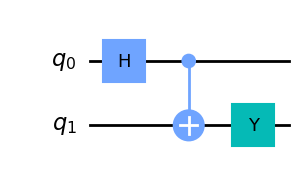

In [4]:
#transformation from |00> to |psi^->:=(|01>-|10>)/sqrt(2)
Vas_q = QuantumRegister(2, 'q')
Vas = QuantumCircuit(Vas_q, name='Vas')
Vas.h(0)
Vas.cx(0,1)
Vas.y(1)
Vas.draw('mpl')

In [5]:
#CG transform of 1+1 qubits
#Transformation from |i_1 i_2 0> to |j_1 m_1 m_2>
q = QuantumRegister(3, 'q')
CG2 = QuantumCircuit(q, name='CG2')
CG2.ccx(q[0],q[1],q[2])
CG2.cx(q[1],q[0])
CG2.append(RYGate(pi/2).control(1,ctrl_state=0), [q[2],q[1]])
CG2.append(RYGate(pi/2).control(2,ctrl_state=0), [q[2],q[0],q[1]])
CG2.cx(q[1],q[0],ctrl_state=0)
CG2.swap(q[0],q[1])
CG2.swap(q[1],q[2])

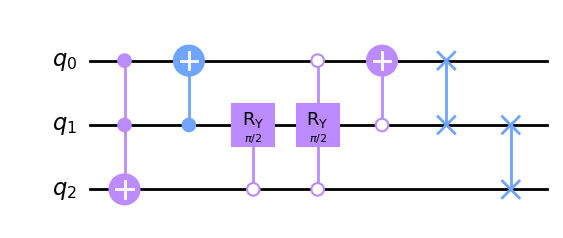

In [6]:
CG2.draw('mpl')

In [7]:
#CG transform of 2+1 qubits
#Transformation from |j_1 m_1 m_2 i_3> to |j'_1 m'_1 m'_2 p'_3>
theta=2.0*np.arccos(np.sqrt(2/3))

q = QuantumRegister(4, 'q')
CG3 = QuantumCircuit(q, name='CG3')

CG3.cx(q[0],q[2],ctrl_state=0)
CG3.ccx(q[2],q[3],q[1])
CG3.cx(q[3],q[2])
CG3.cx(q[1],q[2])
CG3.append(RYGate(pi).control(1,ctrl_state=0),[q[1],q[3]])
CG3.append(RYGate(-theta).control(3,ctrl_state=5),[q[0],q[1],q[2],q[3]])
CG3.append(RYGate(theta).control(3,ctrl_state=7),[q[0],q[1],q[2],q[3]])
CG3.cx(q[3],q[0])
CG3.x(q[0])
CG3.swap(q[1],q[2])
CG3.x(q[1])
CG3.cx(q[0],q[1])
CG3.cswap(q[0],q[1],q[2])
CG3.ccx(q[0],q[1],q[2])

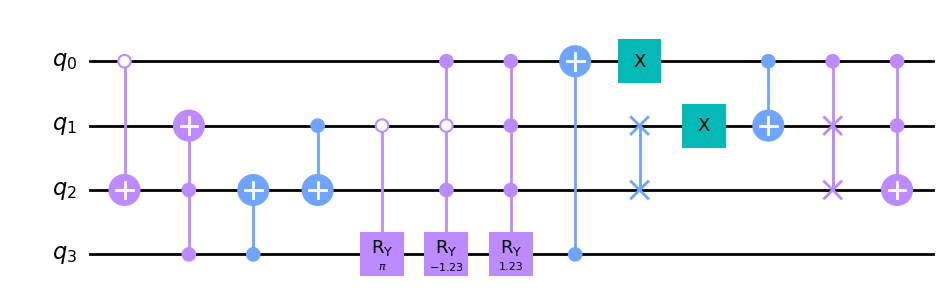

In [8]:
CG3.draw('mpl')

In [9]:
#Input unitary is chosen randomly
Uin =quantum_info.random_unitary(2)

In [10]:
#a block of quantum circuit using 2 calls of the input unitary
q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
block = QuantumCircuit(q,a, name='block')

block.unitary(Uin, q[1], label="Uin")
block.append(CG2, [q[0],q[1],a[0]])
block.cx(q[0], a[3], ctrl_state=1)
block.append(CG3.inverse(), [a[1],a[2],q[2],a[3]])
block.unitary(Uin, a[3], label="Uin")
block.append(CG3, [q[0],q[1],a[0],a[3]])
block.cx(a[1],a[3], ctrl_state=1)
block.append(CG2.inverse(), [a[1], a[2], q[2]])
block.swap(a[0],q[0])
block.swap(a[2],q[1])
block.swap(a[1],q[2])

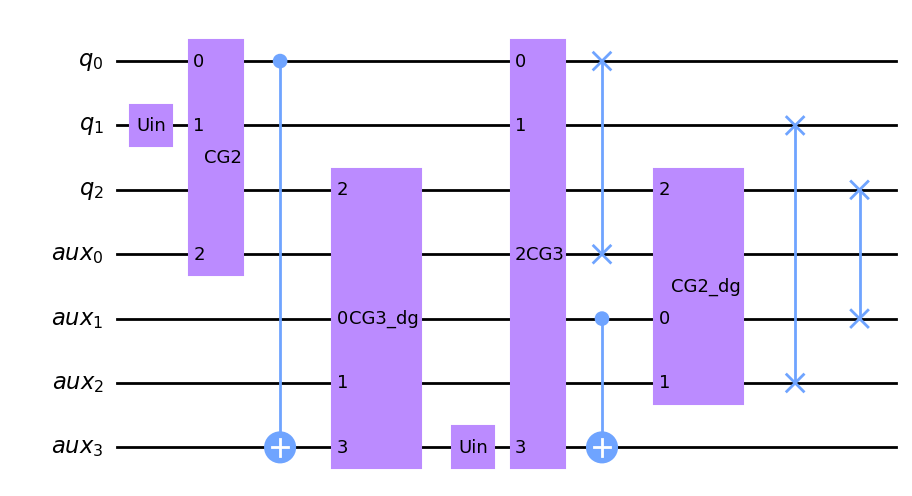

In [11]:
block.draw('mpl')

In [12]:
#Unitary inversion circuit
#Transforming |\psi, 0, 0> to (U\otimes \1)|as>\otimes U^-1 |\psi>
q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
circ = QuantumCircuit(q,a,name='circ')

circ.append(Vas,[q[1],q[2]])
circ.append(block, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])
circ.append(block, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])

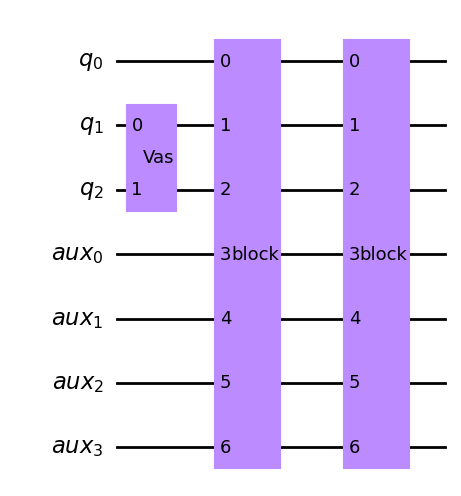

In [13]:
circ.draw('mpl')

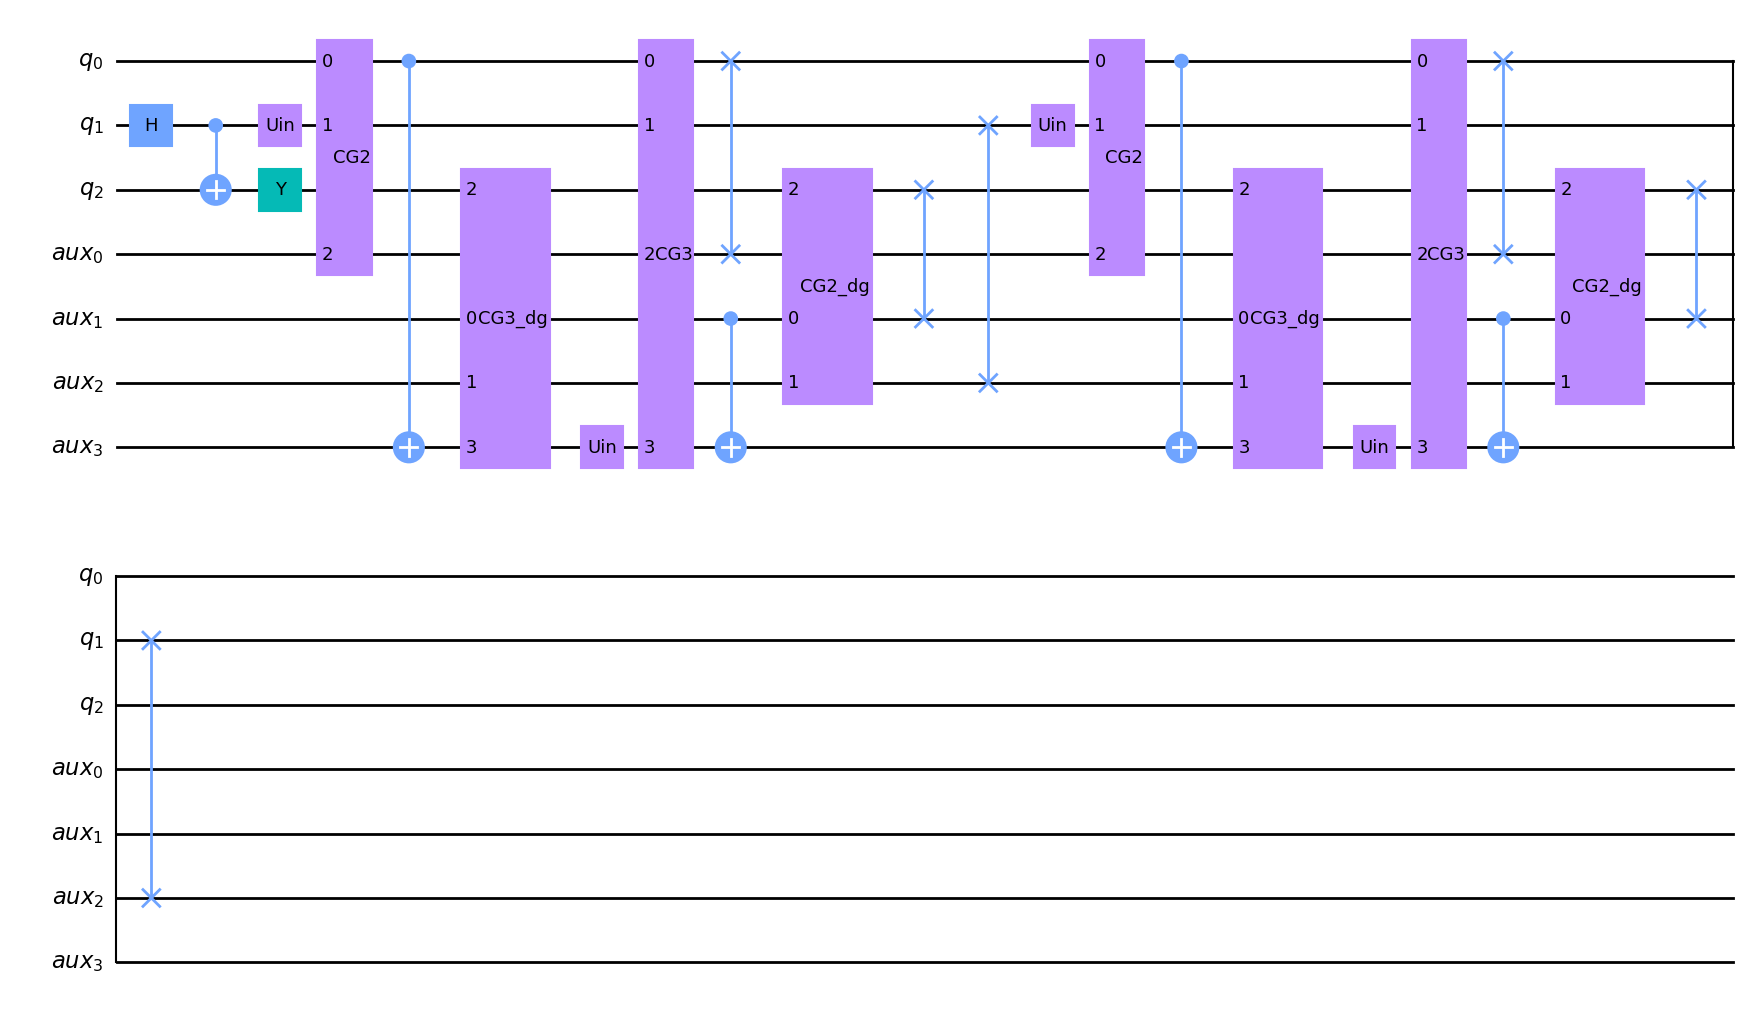

In [14]:
circ=circ.decompose()
circ.draw('mpl')

In [15]:
#Unitary to prepare input state from |0>
prep=quantum_info.random_unitary(2)

In [16]:
#Checking that "circ" implements a transformation from |\psi, 0, 0> to (U\otimes I)|as>\otimes U^-1 |\psi>
q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
c = ClassicalRegister(3, 'c')
check_circ = QuantumCircuit(q,a,c)

check_circ.unitary(prep,q[0],label="prep")
check_circ.append(circ, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])
check_circ.unitary(Uin, q[2], label="Uin")
check_circ.unitary(prep.adjoint(), q[2], label="prep_dg")
check_circ.unitary(Uin.adjoint(), q[0], label='Uin_dg')
check_circ.append(Vas.inverse(), [q[0],q[1]])
check_circ.measure(q[0],c[0])
check_circ.measure(q[1],c[1])
check_circ.measure(q[2],c[2])

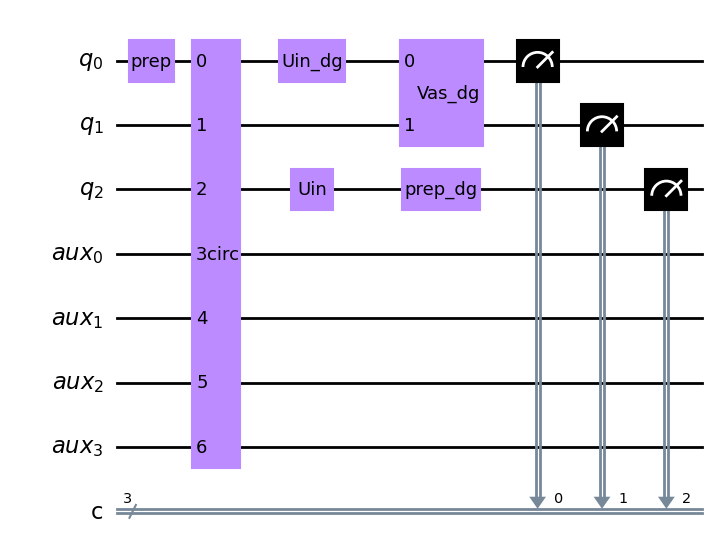

In [17]:
check_circ.draw('mpl')

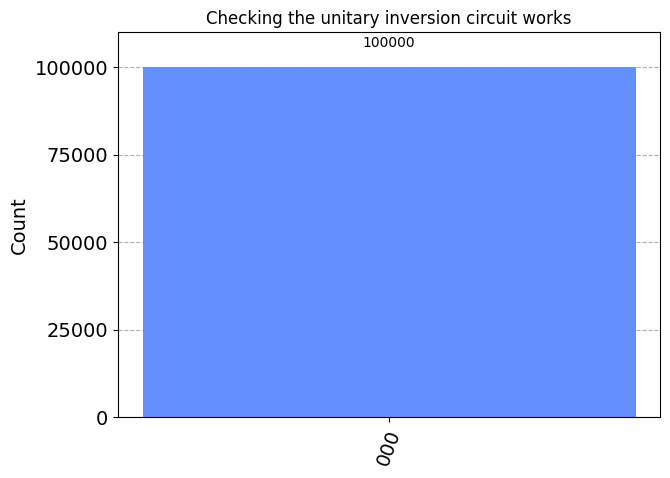

In [18]:
# Transpile for simulator
simulator = Aer.get_backend('aer_simulator')
check_circ = transpile(check_circ, simulator)

# Run and get counts
result = simulator.run(check_circ,shots=100000).result()
counts = result.get_counts(check_circ)
plot_histogram(counts, title='Checking the unitary inversion circuit works')

## Unitary inverser to use

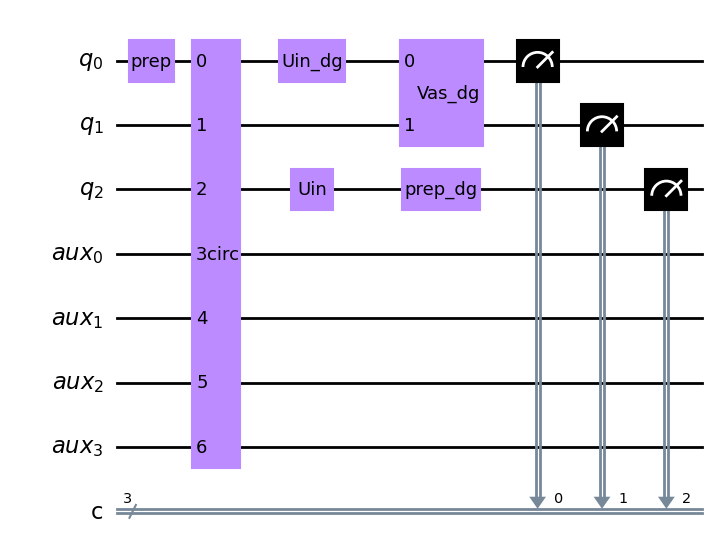

In [19]:
prep=quantum_info.random_unitary(2)

q = QuantumRegister(3, 'q')
a = QuantumRegister(4, 'aux')
c = ClassicalRegister(3, 'c')
u_inverser = QuantumCircuit(q,a,c)

u_inverser.unitary(prep,q[0],label="prep")
u_inverser.append(circ, [q[0],q[1],q[2],a[0],a[1],a[2],a[3]])

u_inverser.unitary(Uin, q[2], label="Uin")
u_inverser.unitary(prep.adjoint(), q[2], label="prep_dg")
u_inverser.unitary(Uin.adjoint(), q[0], label='Uin_dg')
u_inverser.append(Vas.inverse(), [q[0],q[1]])

u_inverser.measure(q[0],c[0])
u_inverser.measure(q[1],c[1])
u_inverser.measure(q[2],c[2])
u_inverser.draw('mpl')

## Ideal result

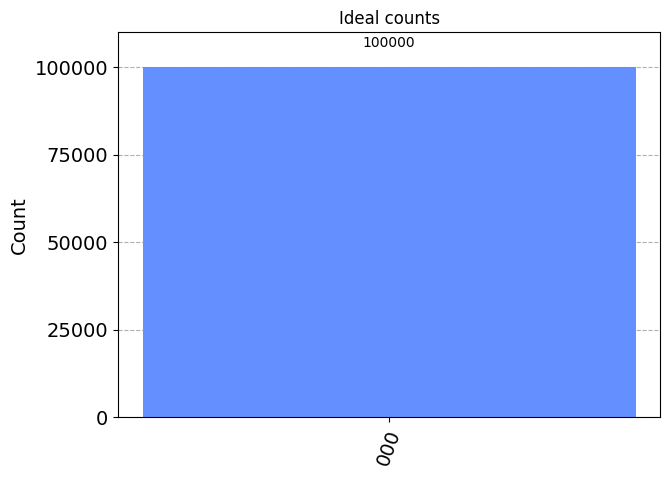

In [20]:
simulator = Aer.get_backend('aer_simulator')
u_inverser_ideal= transpile(u_inverser, simulator)

# Run and get counts
result = simulator.run(u_inverser_ideal,shots=100000).result()
counts = result.get_counts(u_inverser_ideal)
plot_histogram(counts, title='Ideal counts')

## Experiment

### UNM

We will run  multiple experiments on IBM QPUs. 

We will use a noise model based on UNM. It will be initialized with the calibration data of each QPU (it can be get through IBM Quantum Platform).

For the error mitigation, we will use zero-noise extrapolation from Mitiq, with some basic parameters took from "How do i use ZNE?" Mitiq tutorial. This parameters are:
* Linear factory with scale factor 1.0 and 2.0
* a noise scaling based on folding gates at random

Los god fueron con RichardsonFactory(scale_factors=[1,1.5,2,2.5,3]),fold_gates_at_random y num_to_average=3

In [21]:
#MOSTRAR BACKENDS DE IBMQ
IBMProvider.save_account(token= token, overwrite=True)
provider = IBMProvider()
print(provider.backends())

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_statevector')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_kyoto')>, <IBMBackend('ibm_osaka')>]


In [22]:
def create_executor(observable,shots,device):
    def executor(circuit):
        result = device.run(circuit,shots=shots).result()
        counts = result.get_counts(circuit)
        #print(counts)
        return counts[observable]
    return executor

In [1]:
shots = 100000
shots_qpuzne=10000
QPUs = ['ibm_brisbane','ibm_osaka','ibm_kyoto']
conditions = ['qpu','qpu_zne','sim','sim_zne']
strings = ['000','001','010','011','100','101','110','111']
strings = ['000']
string = '000'
pasado = [1,2,3,5,6,7,8,9,10,11,12]
#2 no esta, es el errorcito de ECR != CX xdd
itr = 0
transpiled_circuits_conditionqpu = []
transpiled_circuits_conditionqpuzne = []
transpiled_circuits_conditionsimnoisy = []
transpiled_circuits_conditionsimzne = []

for qpu in QPUs:
    print('............................................................')
    print('-----------------------------------------------------------')
    print('CURRENT QPU:',qpu)
    print('-----------------------------------------------------------')
    print('............................................................')
    backend = provider.get_backend(qpu)
    
    unm = Unified_Noise_Model()
    unm.add_calibration_data(str("./"+qpu+".csv"),['id', 'rz', 'sx', 'x'],['ecr'],backend)
    unm.print_calibration_data()
    unm.add_all_noise_channels2()
    simulator = AerSimulator(noise_model=unm.noise_model)
    for condition in conditions:
        itr = itr + 1 
        print('ITRRR',itr)
        if itr in pasado:
            continue
        if condition == 'qpu':
            print('-----------------------------------------------------------')
            print('------------------',qpu,': real hardware-----------------------')
            print('-----------------------------------------------------------') 
            u_inverser_trans= transpile(u_inverser, backend)
            
            dump(u_inverser_trans,'./%s_%s_qasm'%(str(qpu),str(condition)))       
            
            result = backend.run(u_inverser_trans,shots=shots).result()      
           
            with open('./%s_%s_result'%(str(qpu),str(condition)), 'w') as archivo:
                json.dump(result.to_dict(), archivo)
                  
        if condition == 'qpu_zne':
            print('-----------------------------------------------------------')
            print('------------------',qpu,': real hardware+ZNE-----------------------')
            print('-----------------------------------------------------------') 
            u_inverser_trans= transpile(u_inverser, backend,basis_gates=['id', 'rz', 'sx', 'x','cx'])
            
            dump(u_inverser_trans,'./%s_%s_qasm'%(str(qpu),str(condition)))

            extrapolations = {}
            linear_fac = LinearFactory(scale_factors=[1.0, 2.0])
            for string in strings:
                executor =create_executor(string,shots_qpuzne,backend)
                extrapolations[string] = zne.execute_with_zne(u_inverser_trans, executor,factory=linear_fac,scale_noise=fold_gates_at_random)

            with open('./%s_%s_result'%(str(qpu),str(condition)), 'w') as archivo:
                json.dump(extrapolations, archivo)

        if condition == 'sim':
            print('-----------------------------------------------------------')
            print('------------------',qpu,': simulation-----------------------')
            print('-----------------------------------------------------------')
            #Mitiq doesnt support ECR. ECR can be decomposed to rz,sx and cx. So, for transpile, we change ECR for cx.
            u_inverser_trans= transpile(u_inverser, backend,basis_gates=['id', 'rz', 'sx', 'x','cx'])
    
            dump(u_inverser_trans,'./%s_%s_qasm'%(str(qpu),str(condition)))

            result = simulator.run(u_inverser_trans,shots=shots).result()      

            with open('./%s_%s_result'%(str(qpu),str(condition)), 'w') as archivo:
                json.dump(result.to_dict(), archivo)

        if condition == 'sim_zne':
            print('-----------------------------------------------------------')
            print('------------------',qpu,': simulation+ZNE-----------------------')
            print('-----------------------------------------------------------') 
            #Mitiq doesnt support ECR. ECR can be decomposed to rz,sx and cx. So, for transpile, we change ECR for cx.
            u_inverser_trans= transpile(u_inverser, backend,basis_gates=['id', 'rz', 'sx', 'x','cx'])
            
            dump(u_inverser_trans,'./%s_%s_qasm'%(str(qpu),str(condition)))

            extrapolations = {}
            #linear_fac = LinearFactory(scale_factors=[1.0,2.0])

            #Este LinearFactory te asegura (parece que con bastante probabilidad) que extrapole a un valor con la pendiente correcta para |000>
            #linear_fac = LinearFactory(scale_factors=[1,6])

            #Se corre un LinearFactory al principio para saber la pendiente, luego la suficiente cantidad de estos linear_fac hasta lograr uan extrapolacion
            # con la misma pendiente que el del adaExp
            #dos rich. para probar con diferente cantidad scale factors, la cantidad define a 1que polyfactory equivale.
            linear_fac = RichardsonFactory(scale_factors=[1,1.22,1.44,1.66,2])
            
            #una pruebita con factory exponencial
            #linear_fac = ExpFactory(scale_factors=[1,1.22,1.44,1.66,2],asymptote=0.5)
            for i in range(20):
                #NUEVA GRAN CANDIDATA,POCO AVANCE PERO CON GRAN PROBABILIDAD DE ACIERTO EN PENDIENTE
                linear_fac = LinearFactory(scale_factors=[1,6])
                
                #esta otra es interesante, sacrificas un poco de prob de exito por pendientes...cuando acertas es con mayor precision
                #linear_fac = RichardsonFactory(scale_factors=[1,2,6])
                
                #y este??? una variabcion del clasico richardson extremo....es menos extremo pero parece tener menor tasa de exito
                #linear_fac = RichardsonFactory(scale_factors=[1,1.22,1.44,1.66,2])

                #version aun mas light del anterior
               # linear_fac = RichardsonFactory(scale_factors=[1,1.26,1.52,3,6])

                
                print(string,'-',i,':')
                executor =create_executor(string,10000,simulator)
                extrapolations[string] = zne.execute_with_zne(u_inverser_trans, executor,factory=linear_fac,scale_noise= fold_gates_at_random,num_to_average=1)
                display(linear_fac.plot_fit())

            with open('./%s_%s_result_adaptative'%(str(qpu),str(condition)), 'w') as archivo:
                json.dump(extrapolations, archivo)

'''
EL PROBLEMA ES QUE ESTAS HACIENDO LA TRANSPILACION A CXs, PERO LOS HARDWARE NO TOLERAN ESA COMPUERTA TIENE QUE SER A ECR. PERO A SU VEZ MITIQ NO TOLERA ECR,
NECESITA CX. VAS A TENER QUE VER ESO
'''


............................................................
-----------------------------------------------------------
CURRENT QPU: ibm_brisbane
-----------------------------------------------------------
............................................................


NameError: name 'provider' is not defined

In [57]:
linear_fac.get_zero_noise_limit()
extrapolations

{'000': 5224.5713599296405}

In [26]:
backend = provider.get_backend('ibm_osaka')
print(backend.properties().faulty_qubits())


[16, 106]


In [25]:
backend = provider.get_backend('ibm_kyoto')

unm = Unified_Noise_Model()
unm.add_calibration_data("./ibm_kyoto.csv",['id', 'rz', 'sx', 'x'],['ecr'],backend)

In [11]:
unm.print_calibration_data()

------------------------------------------------
SINGLE QUBIT BASIS GATES:
['id', 'rz', 'sx', 'x']
------------------------------------------------
TWO QUBITS BASIS GATES:
['ecr']
------------------------------------------------
QUBITS:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
------------------------------------------------
SINGLE QUBIT ERROR RATES:


{0: 0.0006428211045,
 1: 0.0003793510479,
 2: 0.0003364645537,
 3: 0.0005826297207,
 4: 0.000310477129,
 5: 0.000299373024,
 6: 0.0001300813342,
 7: 0.0001617923984,
 8: 0.0003004170278,
 9: 0.0001214360774,
 10: 0.0002325574531,
 11: 0.0002130774066,
 12: 0.0001415666494,
 13: 0.0001157447177,
 14: 0.0006299329595,
 15: 0.0001764237807,
 16: 0.000305172547,
 17: 0.0001582508844,
 18: 0.0001678078641,
 19: 0.0002597597788,
 20: 0.0001973569466,
 21: 0.0001963777152,
 22: 0.0008451177088,
 23: 0.0001386059567,
 24: 0.0002534694038,
 25: 0.000204763055,
 26: 0.0001864590504,
 27: 0.0003976994271,
 28: 0.0002391099711,
 29: 0.0004825239137,
 30: 0.003962043303,
 31: 0.000280575833,
 32: 0.0001711474135,
 33: 0.001093089391,
 34: 0.000227364309,
 35: 0.0001731278085,
 36: 0.0001173018415,
 37: 0.0005642471283,
 38: 0.0001577711392,
 39: 0.0003573441937,
 40: 0.0001534963873,
 41: 0.0005183201593,
 42: 0.000249809733,
 43: 0.0001805601069,
 44: 0.0001518465244,
 45: 0.0001196460806,
 46: 0.

------------------------------------------------
TWO QUBITS ERROR RATES:


{'0_14': 0.018035439541048914,
 '1_2': 0.011937455773033512,
 '1_0': 0.01967613490330289,
 '3_2': 0.017769528285786262,
 '4_5': 0.009032544381374324,
 '4_3': 0.012081945549001133,
 '6_5': 0.004440222522439835,
 '7_6': 0.007040548993585777,
 '8_16': 0.01342097383031024,
 '8_9': 0.009595266058450763,
 '8_7': 0.010366129133790924,
 '9_10': 0.003834051563445684,
 '11_10': 0.005837110897643355,
 '11_12': 0.0051689828143164085,
 '12_13': 0.007142145324607468,
 '15_4': 0.005180204601593935,
 '16_26': 0.008000212119215727,
 '17_12': 0.005736722855763904,
 '17_30': 0.01774580846617818,
 '18_14': 0.008645332849595094,
 '18_19': 0.00457812696331264,
 '19_20': 0.004778126944136513,
 '21_20': 0.006466807715695216,
 '22_15': 0.017290195532584707,
 '22_21': 0.019075852309061392,
 '22_23': 0.017474663573964128,
 '23_24': 0.009022021812250647,
 '25_26': 0.004883277401722702,
 '25_24': 0.008166529850622717,
 '27_28': 0.008775670462641771,
 '27_26': 0.008551755486072704,
 '28_35': 0.008710160542538037,
 

------------------------------------------------
MEASUREMENT ERROR RATES:


{0: 0.1517,
 1: 0.0807,
 2: 0.0039,
 3: 0.0885,
 4: 0.0505,
 5: 0.0104,
 6: 0.0227,
 7: 0.0151,
 8: 0.0169,
 9: 0.0088,
 10: 0.0315,
 11: 0.0089,
 12: 0.0053,
 13: 0.006,
 14: 0.1054,
 15: 0.0077,
 16: 0.0066,
 17: 0.0095,
 18: 0.1229,
 19: 0.015,
 20: 0.0117,
 21: 0.0078,
 22: 0.0168,
 23: 0.0087,
 24: 0.0229,
 25: 0.0504,
 26: 0.0074,
 27: 0.0073,
 28: 0.0482,
 29: 0.0252,
 30: 0.0537,
 31: 0.007,
 32: 0.0092,
 33: 0.0193,
 34: 0.0341,
 35: 0.0075,
 36: 0.01,
 37: 0.1275,
 38: 0.0163,
 39: 0.0595,
 40: 0.0101,
 41: 0.0096,
 42: 0.005,
 43: 0.0299,
 44: 0.0088,
 45: 0.0077,
 46: 0.011,
 47: 0.0103,
 48: 0.0195,
 49: 0.0056,
 50: 0.0061,
 51: 0.0132,
 52: 0.011,
 53: 0.0107,
 54: 0.0129,
 55: 0.0069,
 56: 0.012,
 57: 0.1213,
 58: 0.0447,
 59: 0.0199,
 60: 0.0067,
 61: 0.0212,
 62: 0.0084,
 63: 0.0065,
 64: 0.0071,
 65: 0.0095,
 66: 0.0141,
 67: 0.0119,
 68: 0.0561,
 69: 0.0206,
 70: 0.0096,
 71: 0.0271,
 72: 0.0123,
 73: 0.0045,
 74: 0.0057,
 75: 0.0538,
 76: 0.1099,
 77: 0.0952,
 78: 

------------------------------------------------
T1s:
[1.93604781e-04 1.45228083e-04 2.21795981e-04 1.75898791e-04
 1.95748685e-04 2.43749897e-04 2.87996960e-04 3.10600864e-04
 1.76630182e-04 2.87348249e-04 2.74610048e-04 2.19964221e-04
 2.60927755e-04 2.37810082e-04 1.57675618e-04 2.41728342e-04
 2.46775298e-04 2.13659633e-04 2.37964075e-04 3.01029779e-04
 2.63936473e-04 2.70275161e-04 2.02073024e-04 3.11145059e-04
 2.20332102e-04 1.90909802e-04 2.85262739e-04 2.31474818e-04
 2.08973835e-04 2.29614990e-04 1.59107735e-04 2.72873684e-04
 2.80557382e-04 2.18761220e-04 2.63057560e-04 3.71969954e-04
 3.24140872e-04 1.76762088e-04 2.51463558e-04 2.75165993e-04
 2.92868937e-04 1.96258185e-04 1.79419795e-04 3.68852655e-04
 3.08281430e-04 2.52291508e-04 3.01463625e-04 3.03671754e-04
 1.79238358e-04 1.57173135e-04 2.00733425e-04 2.65987624e-04
 2.01401660e-04 3.64224708e-04 2.95673096e-04 1.53589878e-04
 2.10945045e-04 2.50055346e-04 3.11803866e-04 2.89541670e-04
 2.30900959e-04 1.20051476e-04 

In [203]:
unm.add_all_noise_channels2()

In [204]:
unm.noise_model.basis_gates

['cx', 'ecr', 'id', 'rz', 'sx', 'x']

### Simulation - noisy solution

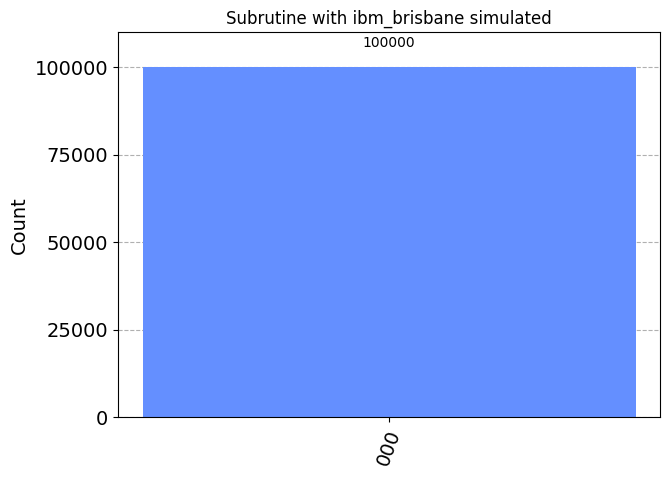

In [25]:
# Transpile for simulator
simulator = AerSimulator(noise_model=unm.noise_model)
u_inverser_noisy = transpile(u_inverser, simulator)
dump(u_inverser_noisy,'./prubea')
# Run and get counts
result = simulator.run(u_inverser_noisy,shots=100000).result()
counts = result.get_counts(u_inverser_noisy)
plot_histogram(counts, title='Subrutine with ibm_brisbane simulated')

In [27]:
def create_executor(observable):
    def executor(circuit):
        result = simulator.run(circuit,shots=100000).result()
        counts = result.get_counts(circuit)
        print(counts)
        return counts[observable]
    return executor

In [30]:
from mitiq import zne

simulator = AerSimulator(noise_model=unm.noise_model)
u_inverser_mitigation = transpile(u_inverser,simulator)
executor =create_executor('000')
from mitiq.zne.scaling import fold_gates_at_random

from mitiq.zne.inference import LinearFactory,RichardsonFactory

linear_fac = RichardsonFactory(scale_factors=[5.0, 8.0])
zne.execute_with_zne(u_inverser_mitigation, executor,factory=linear_fac,scale_noise=fold_gates_at_random)

{'000': 100000}
{'000': 100000}


99999.99999999999

In [243]:
from mitiq import zne

simulator = AerSimulator(noise_model=unm.noise_model)
u_inverser_mitigation = transpile(u_inverser,simulator)
strings = ['000','001','010','011','100','101','110','111']
size_sample = 1

strings_counts=[]
for string in strings:
    print('string ',string)
    executor =create_executor(string)
    mean = 0
    for i in range(size_sample):
        mean += zne.execute_with_zne(u_inverser_mitigation, executor)
    mean = mean / size_sample
    strings_counts.append(mean)

string  000
{'000': 86284, '100': 2087, '010': 3574, '110': 1315, '001': 3710, '101': 1754, '011': 578, '111': 698}
{'000': 80819, '111': 1304, '010': 4472, '100': 2620, '011': 850, '001': 4742, '101': 3222, '110': 1971}
{'000': 75905, '010': 5411, '100': 3007, '111': 1967, '101': 4175, '001': 5322, '011': 1333, '110': 2880}
string  001
{'000': 86144, '101': 1825, '001': 3839, '100': 2173, '010': 3574, '110': 1248, '011': 486, '111': 711}
{'000': 80750, '001': 4752, '010': 4427, '011': 921, '101': 3119, '100': 2616, '110': 2077, '111': 1338}
{'000': 75450, '001': 5443, '101': 4217, '011': 1326, '100': 3039, '110': 3006, '111': 1916, '010': 5603}
string  010
{'000': 86369, '101': 1833, '001': 3692, '100': 2079, '010': 3585, '111': 728, '110': 1190, '011': 524}
{'000': 80169, '011': 927, '010': 4782, '110': 2136, '100': 2639, '101': 3101, '001': 4849, '111': 1397}
{'000': 75454, '001': 5637, '101': 4119, '110': 2936, '100': 3027, '010': 5557, '111': 1967, '011': 1303}
string  011
{'000':

['000', '001', '010', '011', '100', '101', '110', '111']
[92299.99999999993, 2703.999999999993, 1965.9999999999948, -229.00000000000188, 1621.9999999999998, 8.999999999995092, 374.99999999999585, 72.99999999999935]


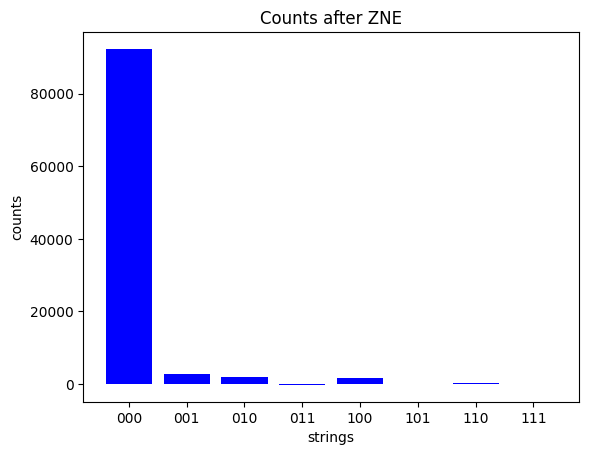

In [244]:
import matplotlib.pyplot as plt

# Sample data
print(strings)
print(strings_counts)
# Create a bar plot
plt.bar(strings, strings_counts, color='blue')

# Add labels and title
plt.xlabel('strings')
plt.ylabel('counts')
plt.title('Counts after ZNE')

# Show the plot
plt.show()